In [ ]:
# imports
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import os
from collections import defaultdict

#### TODO: Data Cleaning

- Decide which columns we want in our final dataset
- Decide if/how we want to split the final datasets
- Decide if/how we combine each of the 9 sets of data
- Visualize/describe data to conform to assignment requirements
- Format ipynb for submission or start a writeup
- Double check the data cleaning

#### TODO: Kalman Filter
- Make a kalman filter for each column (except lat/long, time)
- Make a kalman filter with control for lat/long
- Make a new dataset with filtered data
- Visualize the filtered data

#### TODO: HMM / KMeans
- HMM to classify road quality and road type
- HMM to determine speed and direction from lat/long
- HMM to predict speed limit from speed

#### TODO: ARIMA
- Predict the next speed and direction given previous data

## Guidelines - NEED TO ANSWER THESE

TODO: 
When and how you will hold out data for model evaluation? Explain

(Save totally independent data you have never seen before to evaluate model performance at the end.
If you do want to hold out the same data every time, consider fixing a random seed when you make the test-train split.

Is there any hint that the data you have collected is differently distributed from the actual application of interest?
If so, is there a strategy, such as reweighing samples, that might help?


Action Items

Does what you see change any of your ideas for what models might be appropriate?
Among other things, if your models rely on specific assumptions, is there a way you can check if these assumptions actually hold by looking at the data?
If you are using linear models, do the relevant plots look linear? Is there some other scaling where the model assumptions might more nearly hold?



In [ ]:
# DALLIN'S load data
# dallin_path = "./../data/"
path = '.data/'

# get a list of all the files in the directory
pvss = os.listdir(path)

csvs = []
for pvs in pvss:
    files = os.listdir(os.path.join(path, pvs))
    for file in files:
        if file.endswith(".csv"):
            csvs.append(os.path.join(path, pvs, file))

# load the data
# we have the settings but they don't look that useful
for c in csvs:
    print(c)
gps = pd.read_csv(csvs[0])
left_gps = pd.read_csv(csvs[1])
right_gps = pd.read_csv(csvs[2])
df_labels = pd.read_csv(csvs[3])

# Datasets

For our project, we will use four different datasets and combine them into a single set (joining on the timestamp). Below are what each dataset contains: 

GPS: The following columns are in the GPS dataset: 'timestamp', 'latitude', 'longitude', 'elevation',   'accuracy','bearing', 'speed_meters_per_second', 'provider', 'battery','distance_meters', 'elapsed_time_seconds'. We will drop the following rows from the GPS dataset: 'ageofdgpsdata', "dgpsid", "activity", "annotation", 'hdop', 'vdop', 'pdop', "satellites", "geoidheight". From the GPS dataset, the only missing values are several missing values from bearing at the beginning of the dataset. We drop these rows. 

Left and Right GPS: The following columns are in the Left and Right GPS: 'timestamp', 'acc_x_dash', 'acc_y_dash', 'acc_z_dash', 'acc_x_above', 'acc_y_above', 'acc_z_above', 'acc_x_below', 'acc_y_below','acc_z_below', 'gyro_x_dash', 'gyro_y_dash', 'gyro_z_dash', 'gyro_x_above', 'gyro_y_above', 'gyro_z_above', 'gyro_x_below','gyro_y_below', 'gyro_z_below', 'temp_dash', 'temp_above', 'temp_below','timestamp_gps', 'latitude', 'longitude', 'speed'. The gyro columns contain rotational data from a gyroscope. We drop the following columns as they do not contribute to our modeling: "temp_dash", "temp_above", "temp_below". There are no missing values. 

Dataset Labels: The following columns are in the labels dataset: 'paved_road', 'unpaved_road', 'dirt_road', 'cobblestone_road', 'asphalt_road', 'no_speed_bump', 'speed_bump_asphalt', 'speed_bump_cobblestone', 'good_road_left', 'regular_road_left','bad_road_left', 'good_road_right', 'regular_road_right','bad_road_right'. From this dataset, we create a new dataframe and a score for quality. The following columns are in our new dataframe: 'road', 'condition', 'bumps', 'quality'. There are no missing values. 

In [ ]:
#load 
pvss = os.listdir("data/")
gps = pd.read_csv("data/"+pvss[0])
left_gps = pd.read_csv("data/"+pvss[3])
right_gps = pd.read_csv("data/"+pvss[1])
df_labels = pd.read_csv("data/"+pvss[2])


# Data Cleaning Functions

In [ ]:
def clean_gps(df):
    """
    Clean the gps data by dropping bad rows and columns

    Parameters
    ----------
    df : pd.DataFrame
        The gps data
    
    Returns
    -------
    pd.DataFrame
        The cleaned gps data
    """
    bad_cols = ['ageofdgpsdata', "dgpsid", "activity", "annotation"]
    useless_cols = ['hdop', 'vdop', 'pdop', "satellites", "geoidheight"]

    for col in bad_cols + useless_cols:
        if col in df.columns:
            df = df.drop(columns=[col])
    df = df.dropna()
    return df

In [ ]:
def clean_acc(dirty_df):
    """
    Clean the accelerometer data by dropping bad rows and columns

    Parameters
    ----------
    left : pd.DataFrame
        The left accelerometer data
    right : pd.DataFrame
        The right accelerometer data

    Returns
    -------
    pd.DataFrame
        The cleaned accelerometer data
    """
    useless_cols = ["temp_dash", "temp_above", "temp_below"]
    for col in useless_cols:
        if col in dirty_df.columns:
            dirty_df = dirty_df.drop(columns=[col])
    
    for col in dirty_df.columns:
        if "mag" in col:
            dirty_df = dirty_df.drop(columns=[col])
    
    # remove the word "suspect" from the columns
    dirty_df.columns = dirty_df.columns.str.replace("_suspension", "")
    dirty_df.columns = dirty_df.columns.str.replace("dashboard", "dash")

    dirty_df = dirty_df.dropna()
    
    return dirty_df

In [ ]:
def combine_data(dfs):
    """
    Combine the data into one dataframe by merging on the timestamp column

    Parameters
    ----------
    dfs : list
        A list of dataframes to combine
    
    Returns
    -------
    pd.DataFrame
        The combined dataframe
    """
    df = dfs[0]
    for i in range(1, len(dfs)):
        # merge the dataframes on timestamp
        df = pd.merge(df, dfs[i], on="timestamp")
    return df

In [ ]:
# Function to convert OHE to label
def ohe_to_label(df_in, classes, df_out, class_name):
    conditions = []
    for r in classes:
        conditions.append(df_in[r] == 1)
    df_out[class_name] = np.select(conditions, classes)
    return df_out

# Labels

In [ ]:
label_names = pd.DataFrame(columns = ['road', 'condition','quality_right', 'quality_left','bumps'])

road_classes = ['dirt_road', 'cobblestone_road', 'asphalt_road']
quality_left_classes = ['good_road_left', 'regular_road_left', 'bad_road_left']
quality_right_classes = ['good_road_right', 'regular_road_right', 'bad_road_right']
condition_classes = ['paved_road', 'unpaved_road']
bump_classes=['no_speed_bump', 'speed_bump_asphalt', 'speed_bump_cobblestone']

# Convert from one-hot encoding to single label encoding
label_names = ohe_to_label(df_labels, road_classes, label_names, 'road')
label_names = ohe_to_label(df_labels, quality_right_classes, label_names, 'quality_right')
label_names = ohe_to_label(df_labels, quality_left_classes, label_names, 'quality_left')
label_names = ohe_to_label(df_labels, condition_classes, label_names, 'condition')
label_names = ohe_to_label(df_labels, bump_classes, label_names, 'bumps')

# Convert road quality labels to numeric values
label_names = label_names.replace({'quality_right' : { 'good_road_right' : 2, 'regular_road_right' : 1, 'bad_road_right' : 0 }})
label_names = label_names.replace({'quality_left' : { 'good_road_left' : 2, 'regular_road_left' : 1, 'bad_road_left' : 0 }})
label_names['quality'] = label_names.loc[: , "quality_right":"quality_left"].mean(axis=1)
label_names = label_names.drop(columns = ["quality_right","quality_left"], axis = 1)

label_names.head()

In [ ]:
label_names.columns

# GPS

Something we did not expect to see was the distance_meters and elapsed_time_seconds, we are still unsure of what these columns mean and do not plan to use them. 

In [ ]:
gps['timestamp']

In [ ]:
gps = clean_gps(gps)
gps.head()

In [ ]:
gps.describe()

# Left and Right GPS

In [ ]:
left_gps = clean_acc(left_gps)
right_gps = clean_acc(right_gps)
left_gps.head()

In [ ]:
left_gps.describe()

# Plot Visualizations

In [ ]:
# plot path
plt.scatter(gps['latitude'], gps['longitude'], c=gps['elevation'], cmap='viridis', s=5)
plt.colorbar(label='Elevation')  # Add color bar with label
plt.xlabel('Latitude')
plt.ylabel('Longitude')
plt.xticks(rotation=45)
plt.title('Elevation')
plt.xlim(-27.7,-27.701)
plt.ylim(-51.11, -51.112)
plt.show()

## Path

In [ ]:
# plot path
plt.scatter(gps['latitude'], gps['longitude'], c=gps['elevation'], cmap='viridis', s=1)
plt.colorbar(label='Elevation')  # Add color bar with label
plt.xlabel('Latitude')
plt.ylabel('Longitude')
plt.xticks(rotation=45)
plt.title('Elevation')
plt.show()

In [ ]:
plt.scatter(gps['latitude'], gps['longitude'], c=gps['speed_meters_per_second'], cmap='viridis', s=1)
plt.colorbar(label='Speed (m/s)')  # Add color bar with label
plt.xlabel('Latitude')
plt.ylabel('Longitude')
plt.xticks(rotation=45)
plt.title('Speed')
plt.show()

## Acceleration

In [ ]:
# plot x acceleration
plt.figure(figsize=(10, 10))
sep = 100
end = 20000
plt.subplot(3, 1, 1)
plt.plot(left_gps["acc_x_above"][:end][::sep])
plt.plot(right_gps["acc_x_above"][:end][::sep])
plt.title("X Acceleration Above Suspension")
plt.legend(["Left", "Right"])

plt.subplot(3, 1, 2)
plt.plot(left_gps["acc_x_below"][:end][::sep])
plt.plot(right_gps["acc_x_below"][:end][::sep])
plt.title("X Acceleration Below Suspension")
plt.legend(["Left", "Right"])

plt.subplot(3, 1, 3)
plt.plot(left_gps["acc_x_dash"][:end][::sep])
plt.plot(right_gps["acc_x_dash"][:end][::sep])
plt.title("X Acceleration Dash")
plt.legend(["Left", "Right"])
plt.show()

In [ ]:
# plot y acceleration
plt.figure(figsize=(10, 10))
sep = 100
end = 20000
plt.subplot(3, 1, 1)
plt.plot(left_gps["acc_y_above"][:end][::sep])
plt.plot(right_gps["acc_y_above"][:end][::sep])
plt.title("Y Acceleration Above Suspension")
plt.legend(["Left", "Right"])

plt.subplot(3, 1, 2)
plt.plot(left_gps["acc_y_below"][:end][::sep])
plt.plot(right_gps["acc_y_below"][:end][::sep])
plt.title("Y Acceleration Below Suspension")
plt.legend(["Left", "Right"])

plt.subplot(3, 1, 3)
plt.plot(left_gps["acc_y_dash"][:end][::sep])
plt.plot(right_gps["acc_y_dash"][:end][::sep])
plt.title("Y Acceleration Dash")
plt.legend(["Left", "Right"])
plt.show()

In [ ]:
# plot y acceleration
plt.figure(figsize=(10, 10))
sep = 100
end = 20000
plt.subplot(3, 1, 1)
plt.plot(left_gps["acc_z_above"][:end][::sep])
plt.plot(right_gps["acc_z_above"][:end][::sep])
plt.title("Z Acceleration Above Suspension")
plt.legend(["Left", "Right"])

plt.subplot(3, 1, 2)
plt.plot(left_gps["acc_z_below"][:end][::sep])
plt.plot(right_gps["acc_z_below"][:end][::sep])
plt.title("Z Acceleration Below Suspension")
plt.legend(["Left", "Right"])

plt.subplot(3, 1, 3)
plt.plot(left_gps["acc_z_dash"][:end][::sep])
plt.plot(right_gps["acc_z_dash"][:end][::sep])
plt.title("Z Acceleration Dash")
plt.legend(["Left", "Right"])
plt.show()

## GPS Data

In [ ]:
#set plot 
plt.figure(figsize=(10, 10))
sep = 100
end = 20000

#plot elevation
plt.subplot(3, 1, 1)
plt.plot(gps["elevation"])
plt.title("Elevation")

#plot speed
plt.subplot(3, 1, 2)
plt.plot(gps["speed_meters_per_second"])
plt.title("Speed (m/s)")

#plot battery 
plt.subplot(3, 1, 3)
plt.plot(gps["battery"])
plt.title("Battery")
plt.show()

In [ ]:
def plot_bar_chart(df, variable):
    # Group by 'quality' and the specified variable, and count occurrences
    grouped_data = df.groupby(['quality', variable]).size().reset_index(name='count')

    # Plotting
    fig, ax = plt.subplots(figsize=(10, 6))
    grouped_data.pivot(index=variable, columns='quality', values='count').plot(kind='bar', stacked=True, ax=ax)

    plt.title('Quality and '+variable)
    plt.xlabel(variable)
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.legend(title='Quality')
    plt.tight_layout()
    plt.show()



plot_bar_chart(label_names, 'road')
plot_bar_chart(label_names, 'condition')
plot_bar_chart(label_names, 'bumps')

# Subplots

Comparing the elevation, speed, and course of all 9 different drives.

In [ ]:
path = '.data/'

# get a list of all the files in the directory
pvss = os.listdir(path)

# initialize subplots
fig, ax = plt.subplots(9,2, figsize=(9,27), sharey=True, sharex=True)
i = j = 0

csvs = []
for pvs in pvss:
    files = os.listdir(os.path.join(path, pvs))
    for file in files:
        if file.endswith(".csv"):
            csvs.append(os.path.join(path, pvs, file))
    
    # assign labels
    gps = pd.read_csv(csvs[0])
    left_gps = pd.read_csv(csvs[1])
    right_gps = pd.read_csv(csvs[2])
    df_labels = pd.read_csv(csvs[3])

    # plot path with elevation 
    sc1 = ax[i,j].scatter(gps['latitude'], gps['longitude'], c=gps['elevation'], cmap='viridis', s=1)
    cbar1 = plt.colorbar(sc1, ax=ax[i,j])
    cbar1.set_label('Elevation')
    ax[i,j].set_xlabel('Latitude')
    ax[i,j].set_ylabel('Longitude')
    ax[i,j].set_xticks(ax[i,j].get_xticks(), rotation=45)
    ax[i,j].set_title(f'{pvs} Elevation')
    j += 1

    # plot plath with speed
    sc2 = ax[i,j].scatter(gps['latitude'], gps['longitude'], c=gps['speed_meters_per_second'], cmap='viridis', s=1)
    cbar2 = plt.colorbar(sc2, ax=ax[i,j])
    cbar2.set_label('Speed (m/s)')
    ax[i,j].set_xlabel('Latitude')
    ax[i,j].set_ylabel('Longitude')
    ax[i,j].set_xticks(ax[i,j].get_xticks(), rotation=45)
    ax[i,j].set_title(f'{pvs} Speed')

    i += 1
    j = 0

plt.tight_layout()
plt.show()


A histogram of acceleration data in the x, y, and z direction of all 9 different drives. 

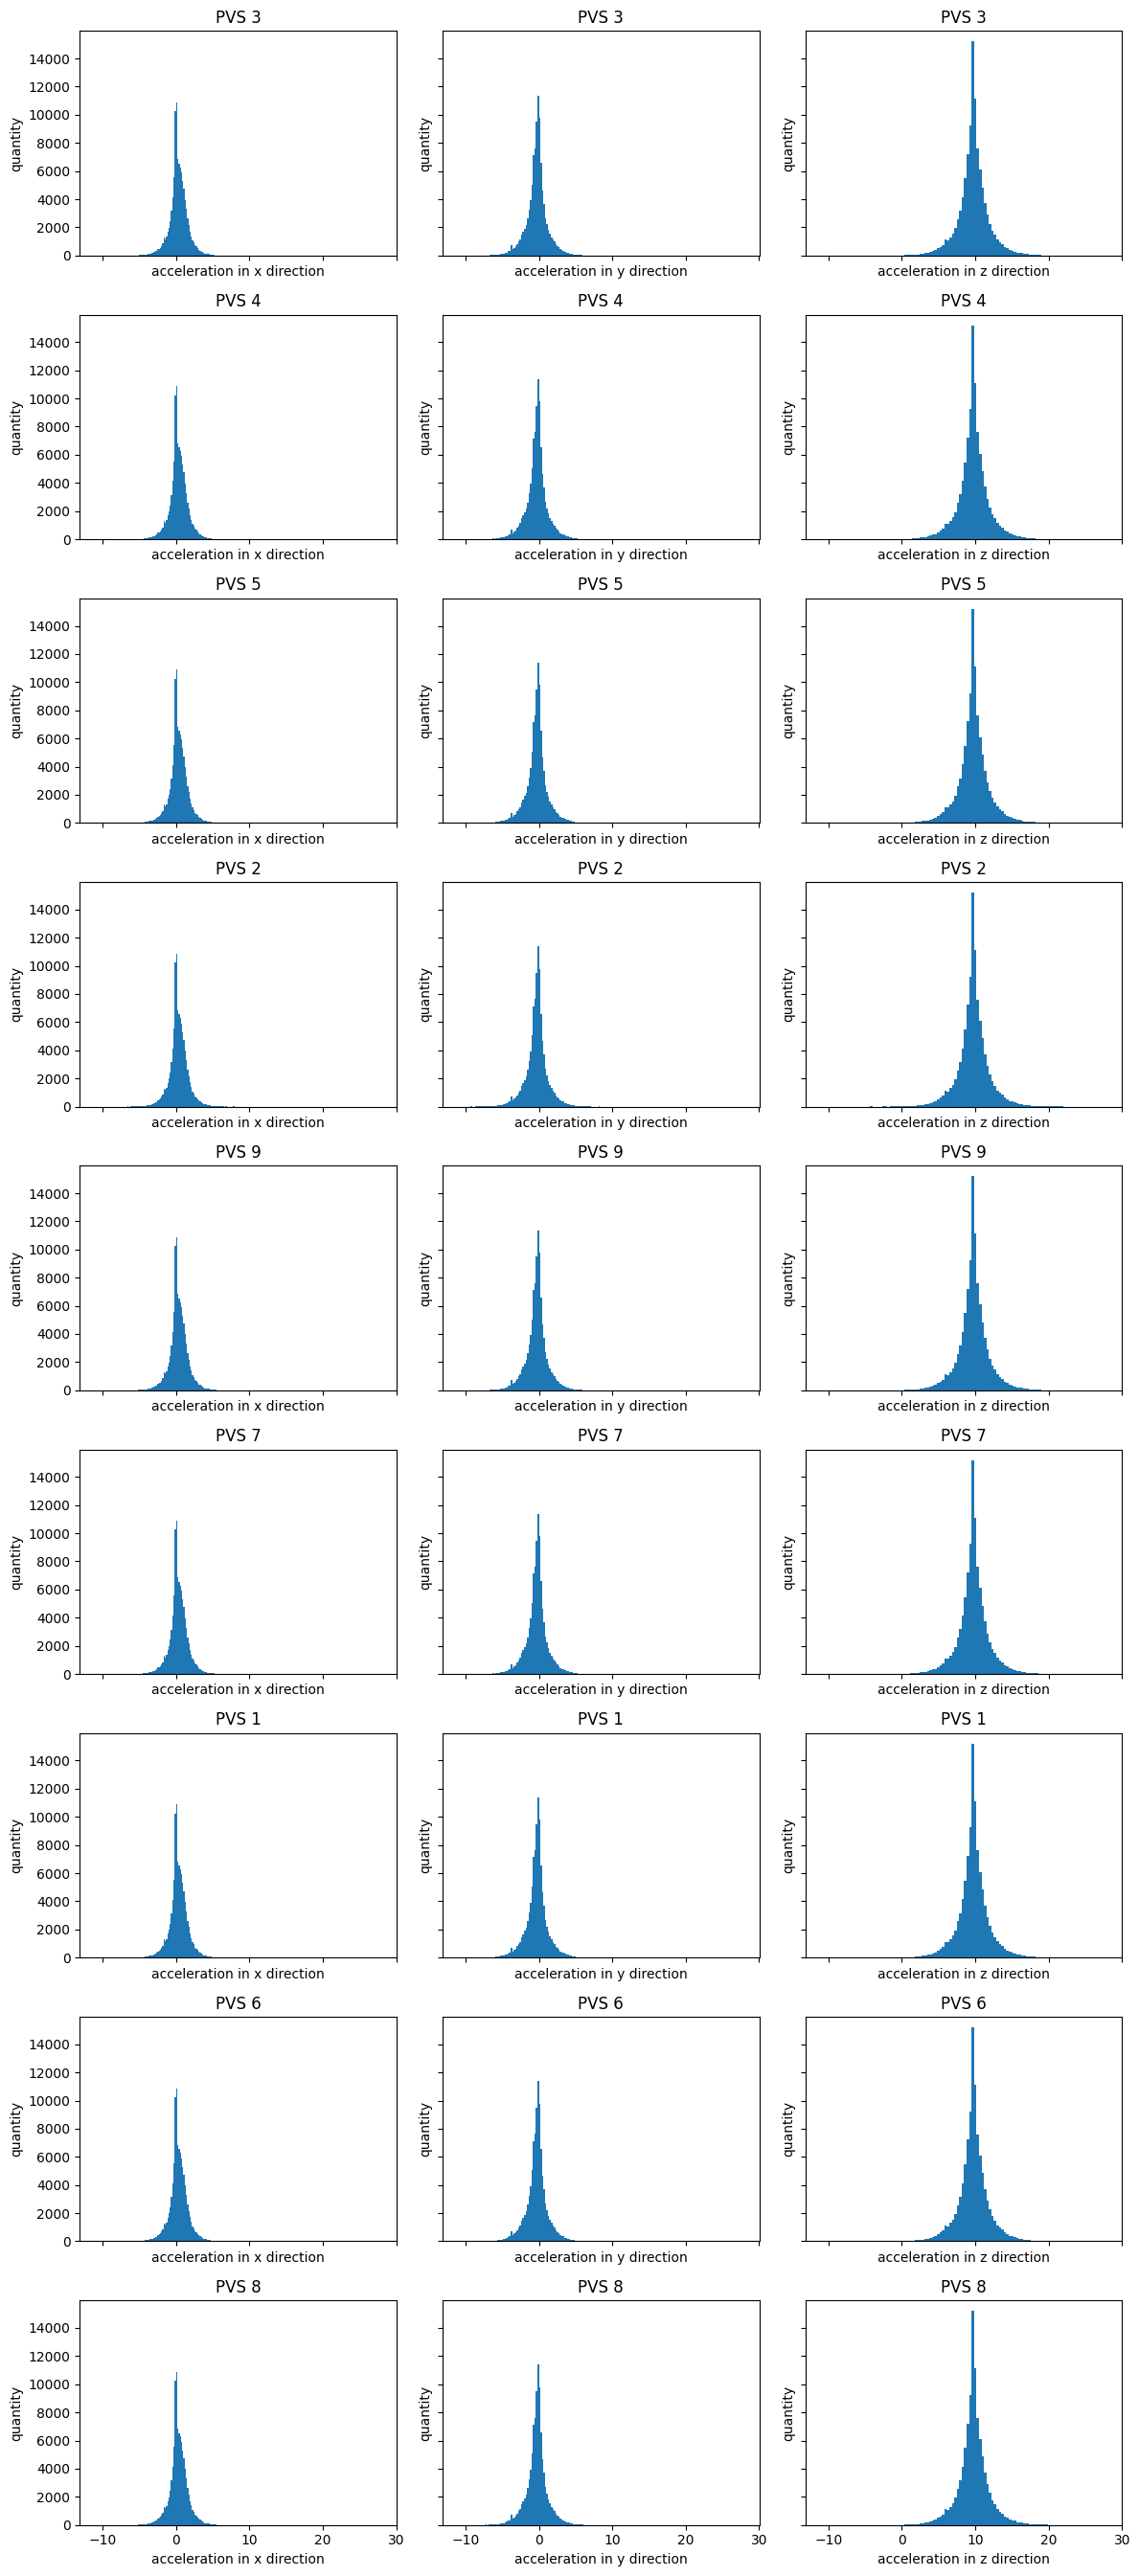

In [81]:
path = '.data/'

# get a list of all the files in the directory
pvss = os.listdir(path)

# initialize subplots
fig, ax = plt.subplots(9,3, figsize=(12,27), sharey=True, sharex=True)
i = j = 0

csvs = []
for pvs in pvss:
    files = os.listdir(os.path.join(path, pvs))
    for file in files:
        if file.endswith(".csv"):
            csvs.append(os.path.join(path, pvs, file))
    
    # assign labels
    gps = pd.read_csv(csvs[0])
    left_gps = pd.read_csv(csvs[1])
    right_gps = pd.read_csv(csvs[2])
    df_labels = pd.read_csv(csvs[3])

    left_gps = clean_acc(left_gps)
    right_gps = clean_acc(right_gps)

    # plot acc in x label
    ax[i,j].hist(left_gps["acc_x_above"], bins=100)
    ax[i,j].set_xlabel('acceleration in x direction')
    ax[i,j].set_ylabel('quantity')
    ax[i,j].set_title(f'{pvs}')
    j += 1

    # plot acc in x label
    ax[i,j].hist(left_gps["acc_y_above"], bins=100)
    ax[i,j].set_xlabel('acceleration in y direction')
    ax[i,j].set_ylabel('quantity')
    ax[i,j].set_title(f'{pvs}')
    j += 1

    # plot acc in x label
    ax[i,j].hist(left_gps["acc_z_above"], bins=100)
    ax[i,j].set_xlabel('acceleration in z direction')
    ax[i,j].set_ylabel('quantity')
    ax[i,j].set_title(f'{pvs}')

    i += 1
    j = 0

plt.tight_layout()
plt.show()
